神经网络架构：具体模型实现
这一部分实现了三种不同的神经网络架构，均继承自 Solver 基类。

A. 基础全连接网络
DNNSolver(Solver)
- 参数： deep_ritz和pinn默认不启用这两种模式，需要手动打开。
- 架构：标准的深度神经网络。
- 结构：
    - 输入层：接收坐标 x。
    - 隐藏层：由 Linear 层和 Tanh 激活函数交替组成。
    - 输入归一化：在 net_u 中将输入坐标映射到 [-1, 1] 区间。

B. 多尺度傅里叶特征网络
FourierFeatureSolver(Solver)
- 目的：解决神经网络拟合高频信号困难的问题（频谱偏差）。
- 核心组件：
    - MultiScaleFourierLayer：
        - 生成基础频率，并通过 2^k 倍频机制生成多尺度频率。
        - 将原始坐标映射到高维傅里叶特征空间。
        - 引入可学习的权重 beta 和归一化尺度 scale。
- 整体结构：傅里叶特征层 + 多层感知机 (ReLU 激活)。

C. 基于注意力机制的傅里叶网络
AttentionFourierSolver(Solver)
- 目的：利用注意力机制动态融合多尺度特征，增强特征交互。
- 核心组件：
    - MultiScaleFourierLayer：同上，作为特征提取前端。
    - CrossAttentionResidualBlock：
        - 跨注意力机制：将傅里叶特征重塑为 Token 序列。
        - Query-Key 交互：使用可学习的 Query 向量聚合所有特征 Token 的信息。
        - 残差更新：通过多层注意力和非线性激活提炼特征。
- 整体结构：傅里叶特征层 -> 注意力特征融合模块 -> 输出层。

# 必备设置

In [76]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from abc import ABC, abstractmethod


def get_fourier_coefficients(x, u):
    """
    计算给定函数在特定频率上的傅里叶系数
    """
    # 目标频率
    x=x.flatten()
    u=u.flatten()
    target_ks = [1, 5, 20]
    coeffs = []
    
    for k in target_ks:
        # 复数傅里叶系数: ∫_{-1}^1 u(x) * exp(-iπk x) dx / 2
        # 使用梯形数值积分
        integrand = u * np.exp(-1j * np.pi * k * x)
        coeff = np.trapezoid(integrand, x) / 2.0
        coeffs.append(coeff)
    return np.array(coeffs)

def solve_poisson_fd(N=2001):
    """
    返回Poisson方程的精确解: -u'' = f(x), u(-1)=u(1)=0
    精确解: u(x) = sin(πx) + sin(5πx) + sin(20πx)
    返回: x[:, None], u[:, None]
    """
    x = np.linspace(-1, 1, N)
    u = np.sin(np.pi * x) + np.sin(5 * np.pi * x) + np.sin(20 * np.pi * x)
    return x[:, None], u[:, None]
class Solver(nn.Module, ABC):
    """
    神经网络求解器的抽象类
    """
    def __init__(self, pinn=False, deep_ritz=False):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.frequency_errors={
            1: [],
            5: [],
            20: []
        }
        self.lb = -1.0
        self.ub = 1.0
        self.boundary_x = np.array([[-1.0], [1.0]])
        self.boundary_u = np.array([[0.0], [0.0]])
        self.N_fd = 2001
        num_internal_points = int(input("请输入用于训练的内部点数量: "))
        # 生成有限差分解作为训练数据
        self.x_fd, self.u_fd = solve_poisson_fd(self.N_fd)
        indices = np.linspace(0, len(self.x_fd)-1, num_internal_points, dtype=int)
        internal_x = self.x_fd[indices]
        internal_u = self.u_fd[indices]
        
        # 构建训练点（边界+内部）
        x_u = np.vstack([self.boundary_x, internal_x])
        u = np.vstack([self.boundary_u, internal_u])
        
        # 转换为张量
        self.lb = torch.tensor(self.lb, dtype=torch.float32).to(self.device)
        self.ub = torch.tensor(self.ub, dtype=torch.float32).to(self.device)
        self.x_u = torch.tensor(x_u, dtype=torch.float32).to(self.device)
        self.u = torch.tensor(u, dtype=torch.float32).to(self.device)
        
        # 物理信息设置
        self.pinn = pinn
        self.deep_ritz = deep_ritz
        # 生成用于计算PDE残差的点
        self.x_f = torch.linspace(self.lb, self.ub, 1000).view(-1, 1).requires_grad_(True).to(self.device)      
        
        # 优化器
        self.optimizer = None

    @abstractmethod
    def net_u(self, x):
        pass

    def net_pinn(self, x):
        """计算PDE残差: -u'' = f -> u'' + f = 0"""
        u = self.net_u(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return u_xx + (torch.pi**2 * torch.sin(torch.pi * x) + 
                        25 * torch.pi**2 * torch.sin(5 * torch.pi * x) + 
                        400 * torch.pi**2 * torch.sin(20 * torch.pi * x))

    def net_deep_ritz(self, x):
        """计算 Deep Ritz 损失"""
        u = self.net_u(x)
        u = (1 - x**2) * u  # 强制满足边界条件
        u_x = torch.autograd.grad(u, x, 
                                  grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        f_x = (torch.pi**2 * torch.sin(torch.pi * x) + 
               25 * torch.pi**2 * torch.sin(5 * torch.pi * x) + 
               400 * torch.pi**2 * torch.sin(20 * torch.pi * x))
        energy_density = 0.5 * (u_x ** 2) - f_x * u
        return torch.mean(energy_density)

    def loss(self):
        # 物理驱动损失
        loss_f = torch.tensor(0.0, device=self.device)
        if self.training:
            if self.deep_ritz:
                loss_f = self.net_deep_ritz(self.x_f)
                return torch.tensor(0.0, device=self.device), loss_f
            elif self.pinn:
                f_pred = self.net_pinn(self.x_f)
                loss_f = torch.mean(f_pred ** 2)
        # 数据驱动损失        
        u_pred = self.net_u(self.x_u)
        if self.deep_ritz:
            u_pred = (1 - self.x_u**2) * u_pred  # 强制满足边界条件
        loss_u = torch.mean((self.u - u_pred) ** 2)
        return loss_u, loss_f
    
    def fit(self, nIter, lr=1e-3):

        self.train()
        
        history = {'error': []}
        
        # 1. 初始化优化器
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.95, patience=200)
        
        
        for i in range(1, nIter+1):
            # 计算损失 
            loss_u, loss_f = self.loss()
            if not self.pinn and not self.deep_ritz:
                # 如果不是 PINN 或 Deep Ritz，则只使用数据驱动损失
                total_loss = loss_u
                if i % 100 == 0:
                    print(f'Iter {i} | Total Loss: {total_loss.item():.3e}')
            elif self.deep_ritz:
                # Deep Ritz 只使用能量损失
                total_loss = loss_f
                if i % 100 == 0:
                    print(f'Iter {i} | Total Loss: {total_loss.item():.3e}')

            else:
                # PINN 情况下使用两种损失的加权和 
                alpha_norm = 0.99  # 用于滑动平均的衰减因子
                if i == 1:
                    avg_loss_f = loss_f.item()
                    avg_loss_u = loss_u.item()
                    loss_f_divid_avg = loss_f
                    loss_u_divid_avg = loss_u

                else:
                    # --- 计算滑动平均值 (指数移动平均) ---
                    # 这一步是为了获得当前损失的“尺度”参考
                    avg_loss_u = alpha_norm * avg_loss_u + (1 - alpha_norm) * loss_u.item()
                    avg_loss_f = alpha_norm * avg_loss_f + (1 - alpha_norm) * loss_f.item()
                    loss_f_divid_avg = loss_f/ np.abs(avg_loss_f)
                    loss_u_divid_avg = loss_u / np.abs(avg_loss_u)

                total_loss = loss_u_divid_avg +2 * loss_f_divid_avg
                
                #  定期打印
                if i % 100 == 0:
                    print(f'Iter {i} | Total Loss: {total_loss.item():.3e}')
                    print(f'Weighted Loss -> u: {loss_u_divid_avg.item():.3e}, f: {loss_f_divid_avg.item():.3e}')
                    print(f'Raw Loss -> u: {loss_u.item():.3e}, f: {loss_f.item():.3e}')
            
            # 单步反向传播和更新
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step(total_loss.item())
            
            # 每10步计算相对误差 
            if i % 10 == 0:
                self.eval()
                with torch.no_grad():
                    x_fd_tensor = torch.tensor(self.x_fd, dtype=torch.float32).to(self.device)
                    u_pred = self.predict(x_fd_tensor)
            
                error = np.linalg.norm(u_pred - self.u_fd) / np.linalg.norm(self.u_fd)
                history['error'].append(error)
                # 计算并记录傅里叶系数误差
                coeffs_pred = get_fourier_coefficients(self.x_fd, u_pred)
                coeffs_fd = get_fourier_coefficients(self.x_fd, self.u_fd)
                for k, coeff_pred, coeff_fd in zip([1, 5, 20], coeffs_pred, coeffs_fd):
                    self.frequency_errors[k].append(np.abs(coeff_pred - coeff_fd) / np.abs(coeff_fd))
                self.train()
            
            # 定期输出误差
            if (i+1) % 100 == 0:
                print(f'Iter {i+1}/{nIter} | Relative Error: {history["error"][-1]:.3e}')
        
        self.plot(history)
        return history
        
    def predict(self, x):
        """预测结果"""
        self.eval()
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            u_pred = self.net_u(x_tensor)
            if self.deep_ritz:
                u_pred=(1-x_tensor**2)*u_pred
        return u_pred.cpu().numpy() 
        
    def plot(self, history):
        """绘制预测结果和相对误差历史"""
        u_pred = self.predict(self.x_fd)
        
        # --- 结果图 ---
        title = "Poisson Equation Solution"
        if self.pinn: title += ' (Physics-Informed)'
        elif self.deep_ritz: title += ' (Deep Ritz)'
        else: title += ' (Data-Driven)'
            
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_fd, self.u_fd, 'k-', label='FD Solution', linewidth=2)
        plt.plot(self.x_fd, u_pred, 'b--', label='Network Prediction', linewidth=2)
        if not self.deep_ritz:
            plt.scatter(self.x_u.detach().cpu().numpy(), 
                    self.u.detach().cpu().numpy(), 
                    color='red', s=10, zorder=5, label='Training Points')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 5))
        # 使用 semilogy 因为误差通常呈指数下降
        plt.semilogy(history['error'], 'r-', label='Relative L2 Error')
        plt.xlabel('Iteration (x10)')
        plt.ylabel('Error (log scale)')
        plt.title('Relative Error History')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# 加入随机傅里叶特征

In [ ]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        base_freqs=(torch.rand(self.base_feature_dim,input_dim)-0.5)*2.0*np.pi
        all_freqs=[]
        for feature in base_freqs:
            for k in range(1,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        self.register_buffer('omega',torch.tensor(all_freqs).reshape(-1,input_dim).float())
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega}")
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi
        self.register_buffer('phases',phases)
        with torch.no_grad():
            beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)
        self.beta=nn.Parameter(beta)
        self.scale=torch.sqrt(torch.tensor(2.0/self.total_feature_dim,dtype=torch.float32))
    def forward(self, x):
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * self.beta
        return features
class FourierFeatureSolver(Solver):
    def __init__(self,layers,base_feature_dim,num_scales):
        super().__init__()
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=1,base_feature_dim=base_feature_dim,num_scales=num_scales)
        input_dim=self.multi_scale_fourier_layer.total_feature_dim
        modules=[]
        modules.append(nn.Linear(input_dim,layers[0]))
        for i in range(0,len(layers)-1):
            modules.append(nn.ReLU())
            modules.append(nn.Linear(layers[i],layers[i+1]))
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_features=self.multi_scale_fourier_layer(x)
        u=self.net(x_features)
        return u

Total feature dim=320. All Fourier feature frequencies:
tensor([[   4.4652],
        [   8.9303],
        [  17.8607],
        [  35.7214],
        [  71.4427],
        [  -0.6002],
        [  -1.2003],
        [  -2.4006],
        [  -4.8012],
        [  -9.6024],
        [  -1.0336],
        [  -2.0672],
        [  -4.1344],
        [  -8.2688],
        [ -16.5376],
        [  -5.4046],
        [ -10.8093],
        [ -21.6186],
        [ -43.2372],
        [ -86.4744],
        [  -6.2746],
        [ -12.5491],
        [ -25.0983],
        [ -50.1965],
        [-100.3931],
        [   3.1354],
        [   6.2708],
        [  12.5416],
        [  25.0832],
        [  50.1664],
        [  -2.3079],
        [  -4.6158],
        [  -9.2315],
        [ -18.4630],
        [ -36.9261],
        [   4.7649],
        [   9.5298],
        [  19.0596],
        [  38.1193],
        [  76.2385],
        [  -5.2793],
        [ -10.5585],
        [ -21.1171],
        [ -42.2342],
        [ -84.4683],

C:\Users\hp\AppData\Local\Temp\ipykernel_19172\245188555.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)
C:\Users\hp\AppData\Local\Temp\ipykernel_19172\2571638274.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)


Iter 100/5000 | Relative Error: 9.977e-01
Iter 100 | Total Loss: 2.993e+00
Weighted Loss -> u: 9.928e-01, f: 1.000e+00
Raw Loss -> u: 1.412e+00, f: 7.815e+06
Iter 200/5000 | Relative Error: 8.239e-01
Iter 200 | Total Loss: 2.763e+00
Weighted Loss -> u: 7.632e-01, f: 1.000e+00
Raw Loss -> u: 9.901e-01, f: 7.815e+06
Iter 300/5000 | Relative Error: 8.082e-01
Iter 300 | Total Loss: 2.872e+00
Weighted Loss -> u: 8.726e-01, f: 9.999e-01
Raw Loss -> u: 9.474e-01, f: 7.814e+06
Iter 400/5000 | Relative Error: 7.844e-01
Iter 400 | Total Loss: 2.897e+00
Weighted Loss -> u: 8.978e-01, f: 9.995e-01
Raw Loss -> u: 8.712e-01, f: 7.809e+06
Iter 500/5000 | Relative Error: 6.062e-01
Iter 500 | Total Loss: 2.625e+00
Weighted Loss -> u: 6.382e-01, f: 9.935e-01
Raw Loss -> u: 4.988e-01, f: 7.740e+06
Iter 600/5000 | Relative Error: 5.668e-01
Iter 600 | Total Loss: 2.757e+00
Weighted Loss -> u: 7.797e-01, f: 9.887e-01
Raw Loss -> u: 4.513e-01, f: 7.636e+06
Iter 700/5000 | Relative Error: 5.549e-01
Iter 700 |

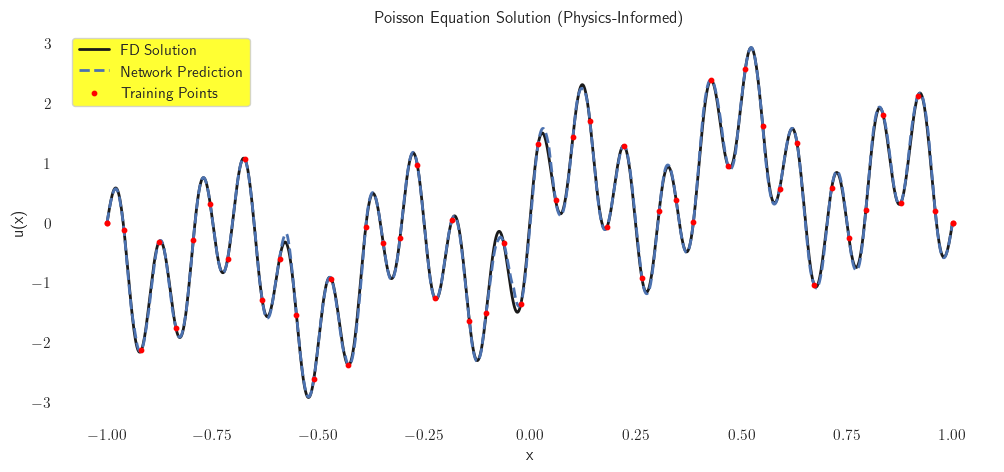

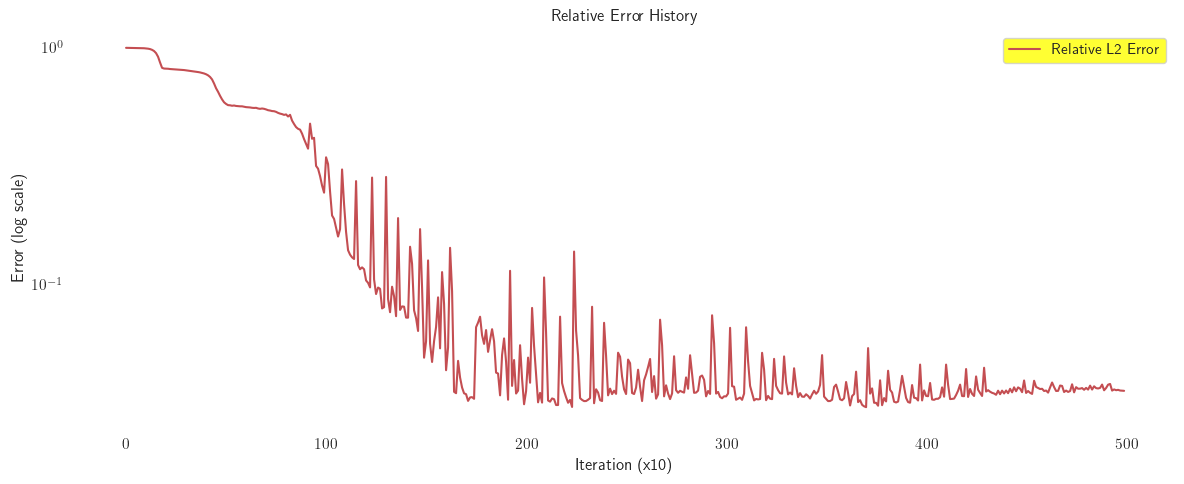

In [109]:
layers=[32,64,64,32,1]
base_feature_dim=64
num_scales=5
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.pinn=True
fourier_solver.fit(5000)
pinn_data=fourier_solver.frequency_errors

In [23]:
class CrossAttentionResidualBlock(nn.Module):
    def __init__(self,N_tok,d_q,num_layers):
        super().__init__()
        self.N_tok=N_tok
        self.d_q=d_q
        self.M = N_tok * d_q
        self.num_layers = num_layers
        self.initial_fc=nn.Sequential(
            nn.Linear(self.M,d_q),
            nn.ReLU()
        )
        self.W_Q = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_K = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_V = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.update_fc=nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_q, d_q),
                nn.ReLU()
            ) for _ in range(num_layers)
        ])
        self.scale=1.0/np.sqrt(d_q)
    
    def forward(self,phi):
        batch_size=phi.shape[0]
        assert phi.shape[1]==self.M, f"Input feature dimension {phi.shape[1]} does not match expected {self.M}"
        H=phi.reshape(batch_size,self.N_tok,self.d_q)
        Q=self.initial_fc(phi)
        for i in range(self.num_layers):
            Q_i=self.W_Q[i](Q)
            K_i=self.W_K[i](H)
            V_i=self.W_V[i](H)
            Q_expanded=Q_i.unsqueeze(1)
            attn_scores=torch.matmul(Q_expanded,K_i.transpose(1,2))*self.scale
            attn_weights=torch.softmax(attn_scores,dim=-1)
            attn_output=torch.matmul(attn_weights,V_i).squeeze(1)
            Q=Q+attn_output
            Q=self.update_fc[i](Q)
        return Q
    
class AttentionFourierSolver(Solver):
    def __init__(self,input_dim,base_feature_dim,num_scales,N_tok,d_q,num_attn_layers):
        super().__init__()
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=input_dim,base_feature_dim=base_feature_dim,num_scales=num_scales)
        self.cross_attention_residual_block=CrossAttentionResidualBlock(N_tok,d_q,num_attn_layers)
        self.output_layer=nn.Linear(d_q,1)
        self.to(self.device)

    def net_u(self,x):
        x_features=self.multi_scale_fourier_layer(x)
        attn_output=self.cross_attention_residual_block(x_features)
        u=self.output_layer(attn_output)
        return u

In [ ]:
regresion_matrix=np.array([regresion_data[20],regresion_data[5],regresion_data[1]])
deep_ritz_matrix=np.array([deep_ritz_data[20],deep_ritz_data[5],deep_ritz_data[1]])
pinn_matrix=np.array([pinn_data[20][:199],pinn_data[5][:199],pinn_data[1][:199]])
matrix_data=[regresion_matrix,deep_ritz_matrix,pinn_matrix]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    'font.family': 'serif',        # 衬线字体
    'font.serif': ['Times New Roman', 'Times', 'Computer Modern Roman'],
    'font.size': 10,                # 基础字号
    'axes.titlesize': 11,           # 标题字号
    'axes.labelsize': 10,           # 坐标轴标签字号
    'xtick.labelsize': 9,           # x轴刻度字号
    'ytick.labelsize': 9,           # y轴刻度字号
    'legend.fontsize': 9,           # 图例字号
})
plt.rcParams['text.usetex'] = True
# 设置图片格式，尽量接近原图的矢量风格
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题，虽然latex通常不需要
# 创建示例数据
np.random.seed(42)

# 1. 创建图形，包含3个子图
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharey=True)
# 调整子图间距
plt.subplots_adjust(wspace=0.1) # 子图间距很小，几乎连在一起

# 定义三个子图的标题
titles = ['Regression', 'Deep Ritz', 'PINN']

# 循环绘制每个子图
for i, ax in enumerate(axes):

    matrix_data_i = matrix_data[i]

    # 绘制热力图
    # 注意：这里没有绘制颜色条(cbar=False)，我们将统一绘制
    heatmap = sns.heatmap(
        matrix_data_i,            # 数据矩阵
        cmap="viridis",        # 颜色映射，_r表示反转，从深蓝(低)到黄(高)
        ax=ax,                  # 指定子图
        cbar=False,             # 不在每个子图单独绘制颜色条
        linewidths=0,           # 边框宽度
        vmin=0, vmax=1          # 设置颜色范围，对应下面的颜色条0到1
    )

    # 设置标题
    ax.set_title(titles[i], fontsize=14)

    # 2. 设置坐标轴标签
    ax.set_xlabel('Epoch', fontsize=12)
    if i == 0:
        ax.set_ylabel('Frequency k', fontsize=12)


    # 3. 设置刻度 (关键步骤，模拟原图的非均匀或特定范围刻度)
    # 原图看起来像是对数刻度或者是非线性分布的采样点
    # 这里我们模拟一种非线性分布的刻度，例如对数分布或特定采样点

    # 模拟Epoch轴 (x轴)
    # 原图中有 1, 40, 80, 120, 160, 200 等标记
    if i == 0:
        # Regression
        x_positions = [0, 9, 19, 29, 39, 49] # 数据矩阵中的位置
        x_labels = ['1', '100', '200', '300', '400', '500']
    elif i == 1:
        # Deep Ritz
        x_positions = [0, 29, 59, 89, 119, 149]
        x_labels = ['1', '300', '600', '900', '1200', '1500']
    else:
        # PINN
        x_positions = [0,39,79,119,159,199]
        x_labels = ['1','400','800','1200','1600','2000']
    ax.set_xticks([pos + 0.5 for pos in x_positions]) # +0.5是为了居中
    ax.set_xticklabels(x_labels, rotation=0)

    # 模拟Frequency k轴 (y轴)
    # 原图中有 1, 5, 10, 15, 20 等标记
    y_positions = [0,  1, 2] # 数据矩阵中的位置
    y_labels = ['20','5','1']  
    ax.set_yticks([pos + 0.5 for pos in y_positions])
    ax.set_yticklabels(y_labels)

# 4. 统一添加颜色条 (Colorbar)
# 获取最后一个子图的位置，用于放置颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
# 创建一个假的ScalarMappable对象用于颜色条，因为热力图没有自带cbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
cmap = plt.get_cmap("viridis")
norm = colors.Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# 添加颜色条
cbar = fig.colorbar(sm, cax=cbar_ax, label='relative error  $  \Delta_F(k)  $ ')
cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# 5. 调整布局并显示
plt.show()

# 加入attention机制

Total feature dim=96. All Fourier feature frequencies:
tensor([[  -4.1314],
        [  -8.2628],
        [ -16.5255],
        [ -33.0511],
        [ -66.1021],
        [-132.2042],
        [   2.5381],
        [   5.0762],
        [  10.1524],
        [  20.3047],
        [  40.6094],
        [  81.2188],
        [   1.2688],
        [   2.5376],
        [   5.0752],
        [  10.1505],
        [  20.3010],
        [  40.6020],
        [   2.7917],
        [   5.5834],
        [  11.1669],
        [  22.3338],
        [  44.6676],
        [  89.3352],
        [  -4.4783],
        [  -8.9567],
        [ -17.9134],
        [ -35.8268],
        [ -71.6535],
        [-143.3071],
        [  -1.5811],
        [  -3.1621],
        [  -6.3243],
        [ -12.6485],
        [ -25.2971],
        [ -50.5942],
        [  -5.8444],
        [ -11.6889],
        [ -23.3778],
        [ -46.7555],
        [ -93.5111],
        [-187.0221],
        [  -6.1954],
        [ -12.3907],
        [ -24.7815],


C:\Users\hp\AppData\Local\Temp\ipykernel_1504\1453690804.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)
C:\Users\hp\AppData\Local\Temp\ipykernel_1504\135285983.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)


Iter 100/3000 | Relative Error: 1.006e+00
Iter 100 | Total Loss: -3.450e-01
Iter 200/3000 | Relative Error: 9.736e-01
Iter 200 | Total Loss: -4.307e+01
Iter 300/3000 | Relative Error: 8.326e-01
Iter 300 | Total Loss: -4.120e+02
Iter 400/3000 | Relative Error: 7.777e-01
Iter 400 | Total Loss: -6.701e+02
Iter 500/3000 | Relative Error: 7.589e-01
Iter 500 | Total Loss: -7.887e+02
Iter 600/3000 | Relative Error: 7.032e-01
Iter 600 | Total Loss: -8.317e+02
Iter 700/3000 | Relative Error: 6.765e-01
Iter 700 | Total Loss: -8.882e+02
Iter 800/3000 | Relative Error: 6.609e-01
Iter 800 | Total Loss: -9.323e+02
Iter 900/3000 | Relative Error: 6.653e-01
Iter 900 | Total Loss: -9.638e+02
Iter 1000/3000 | Relative Error: 6.795e-01
Iter 1000 | Total Loss: -9.746e+02
Iter 1100/3000 | Relative Error: 6.876e-01
Iter 1100 | Total Loss: -9.908e+02
Iter 1200/3000 | Relative Error: 6.911e-01
Iter 1200 | Total Loss: -1.000e+03
Iter 1300/3000 | Relative Error: 6.582e-01
Iter 1300 | Total Loss: -1.008e+03
Iter

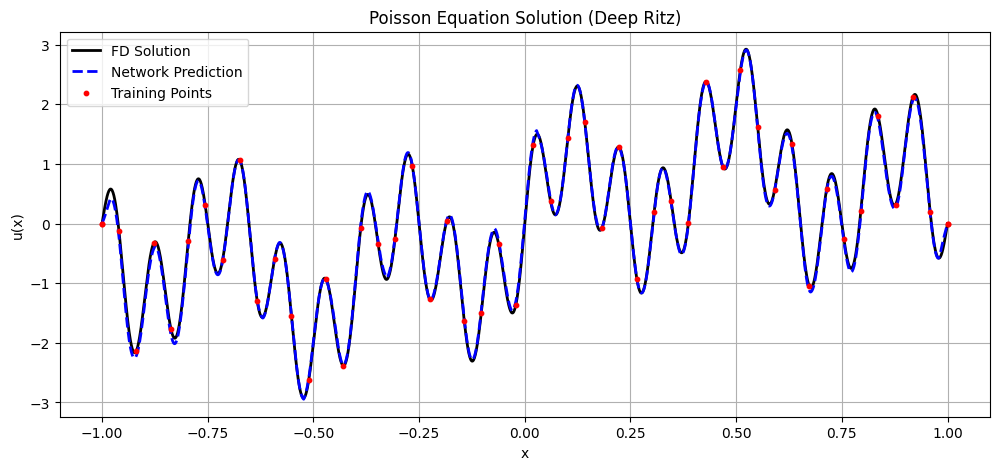

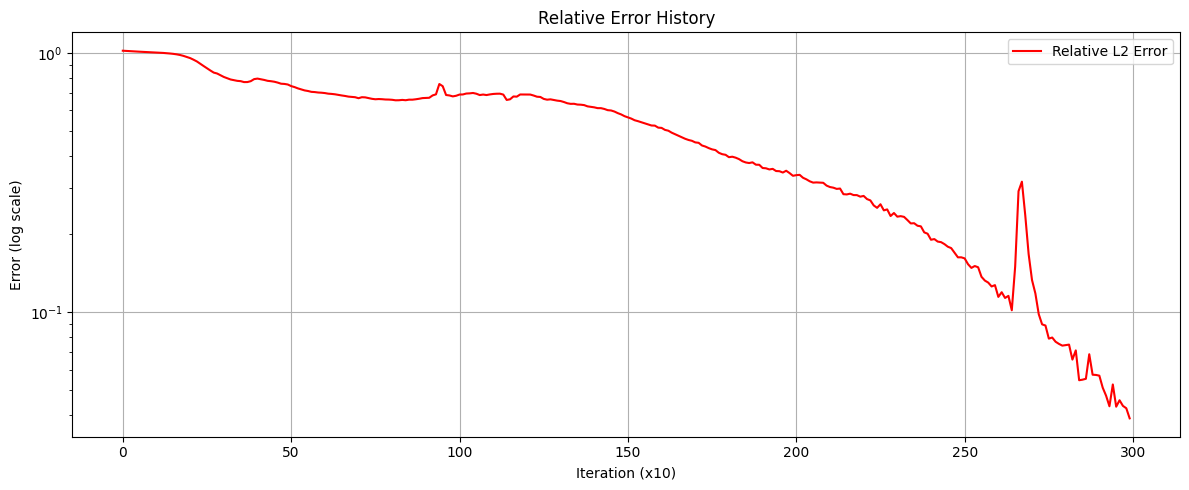

{'error': [np.float64(1.019237834391745),
  np.float64(1.0173283319060271),
  np.float64(1.0154281370882594),
  np.float64(1.0135839229157155),
  np.float64(1.011829999678993),
  np.float64(1.010323327623264),
  np.float64(1.008849121323539),
  np.float64(1.0073579959390118),
  np.float64(1.0059487231549504),
  np.float64(1.0045025852380747),
  np.float64(1.0029320417449823),
  np.float64(1.0012337763817207),
  np.float64(0.9994004075747042),
  np.float64(0.99712493674064),
  np.float64(0.9943642373863394),
  np.float64(0.9911534756923712),
  np.float64(0.9868988928629951),
  np.float64(0.9812217298675293),
  np.float64(0.9735899687207104),
  np.float64(0.9638534975658465),
  np.float64(0.9546154766475653),
  np.float64(0.9411115289017544),
  np.float64(0.9265323511091184),
  np.float64(0.9074148062724032),
  np.float64(0.889627556553496),
  np.float64(0.8718744084384706),
  np.float64(0.8551416959519108),
  np.float64(0.8393113601585571),
  np.float64(0.8325722416467168),
  np.float64

In [24]:
attention_fourier_solver=AttentionFourierSolver(
    input_dim=1,
    base_feature_dim=16,
    num_scales=6,
    N_tok=16,
    d_q=6,
    num_attn_layers=4
)
attention_fourier_solver.deep_ritz=True
attention_fourier_solver.fit(3000)